In [1]:
import pandas as pd
import requests
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [2]:
api_key = "&api_key=4b0cabcc40936fa4272561a54cd95c5c"
base_url = "https://api.stlouisfed.org/fred/series/observations?series_id="
series = ["DGS1MO", "DGS3MO", "DGS1", "DGS2", "DGS5", "DGS10", "DGS20", "DGS30"] # get daily time series
file_type = "&file_type=json"
data = dict()

In [3]:
# get all of the data
for i in series:
    link = base_url+i+api_key+file_type
    r = requests.get(link)
    data[i] = pd.DataFrame(r.json()['observations'])[['date','value']]

In [4]:
lengths = [len(v) for v in data.values()]

In [5]:
for i in series:
    data[i] = data[i][-lengths[0]:] # change the length of the data to the length of the shortest dataset (1 Month T)
    data[i] = data[i].set_index('date')

In [6]:
rates = pd.DataFrame({'DGS1MO':data['DGS1MO'].value,
                    'DGS3MO':data['DGS3MO'].value,
                    'DGS1':data['DGS1'].value,
                    'DGS2':data['DGS2'].value,
                    'DGS5':data['DGS5'].value,
                    'DGS10':data['DGS10'].value,
                    'DGS20':data['DGS20'].value,
                    'DGS30':data['DGS30'].value})

In [35]:
np_rates = rates.to_numpy() # convert to np array

In [36]:
np_rates = np.where(np_rates == '.',0,np_rates) # replace bad values

In [37]:
np_rates = np_rates.astype(float) #convert to float

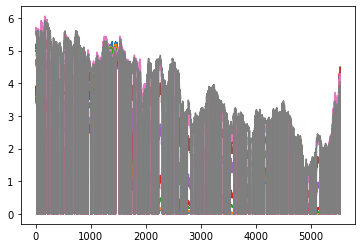

In [38]:
plt.plot(np_rates)
plt.show()

In [76]:
#de-mean
mu_rates = np.mean(np_rates, axis=0)
data = np_rates - mu_rates

Q = np.cov(data.T)
correl = np.corrcoef(data.T)

find eigenvalues

In [77]:
F, V = LA.eigh(Q)

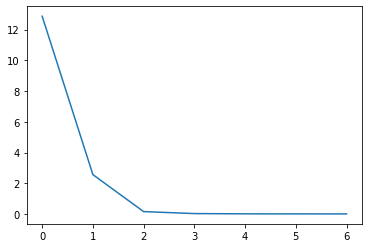

In [78]:
plt.plot(F[-1:-8:-1])

In [79]:
e_indices = np.argsort(F)[::-1]
eigenvectors_sorted = V[:,e_indices]
eigenvectors_sorted

array([[-0.36223014,  0.34973025,  0.50753425, -0.42310167, -0.09392326,
         0.35031163, -0.38816718,  0.16630834],
       [-0.37215961,  0.35744909,  0.33144949,  0.01405006,  0.11032425,
        -0.33179576,  0.60050289, -0.37524341],
       [-0.3870489 ,  0.31101723, -0.14905941,  0.53932046,  0.17554801,
        -0.28184674, -0.20885792,  0.5352568 ],
       [-0.38418408,  0.19383627, -0.48139358,  0.24190015, -0.23677047,
         0.43438735, -0.13028772, -0.51268618],
       [-0.364573  , -0.10381627, -0.49112843, -0.54337872, -0.15332428,
        -0.02641644,  0.37765388,  0.39116815],
       [-0.33086329, -0.3371408 , -0.0862759 , -0.26485292,  0.20792615,
        -0.53499687, -0.5003448 , -0.34565172],
       [-0.32339133, -0.48564437,  0.14200096,  0.14359934,  0.61534587,
         0.45465782,  0.17598861,  0.04945985],
       [-0.2931149 , -0.50529446,  0.33132582,  0.29219352, -0.66838422,
        -0.07368966,  0.06470416,  0.08516487]])

In [80]:
explained_variance = (F[::-1]/F.sum())*100

In [81]:
print("Explained Variance for Numpy PCA")
print("First Component:",np.round(explained_variance[0],1),"%\nSecond Component:", np.round(explained_variance[1],1),"%\nThird Component:", np.round(explained_variance[2],1),"%")

Explained Variance for Numpy PCA
First Component: 82.4 %
Second Component: 16.4 %
Third Component: 1.0 %


Power Method

In [82]:
def runpower(matrix, n):
    #get initial vector

    v = np.zeros(n)
    w = np.zeros(n)

    for j in range(n):
        v[j] = np.random.uniform(0,1)

    #print 'matrix', matrix
    #print 'v', v

    maxiters = 1000
    tolerance = 1e-10
    oldnormw = 0
    for t in range(maxiters):
        w = matrix.dot(v)
        #print 't', t, 'w',w
        normw = (np.inner(w,w))**.5
        
        v = w/normw
        #print 't',t,'v',v

        #print 't',t,'normw',normw, 'old', oldnormw
        if np.abs(normw - oldnormw)/normw < tolerance:
            #print ' breaking'
            break
        oldnormw = normw

    return normw, v    

In [83]:
runpower(Q,Q.shape[0])

(12.87285302853166,
 array([0.36223019, 0.37215967, 0.38704894, 0.38418411, 0.36457299,
        0.33086324, 0.32339126, 0.29311483]))

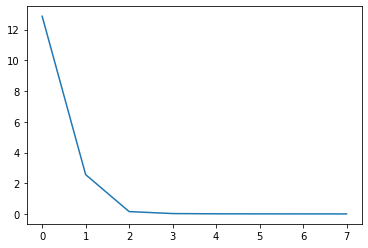

In [88]:
v = {}
N = Q_copy.shape[0]
val = np.zeros(N)
Q_copy = Q
for j in range(N):
    val[j], v[j] = runpower(Q_copy,Q_copy.shape[0])
    #print('eigenvalue {:3d}: {:.4e}'.format(j, val[j]))
    Q_copy = Q_copy - val[j]*np.outer(v[j], v[j])
plt.plot(val)

In [89]:
explained_variance_pow = (val/val.sum())*100

In [90]:
print("Explained Variance for Power Method")
print("First Component:",np.round(explained_variance_pow[0],1),"%\nSecond Component:", np.round(explained_variance_pow[1],1),"%\nThird Component:", np.round(explained_variance_pow[2],1),"%")

Explained Variance for Power Method
First Component: 82.4 %
Second Component: 16.4 %
Third Component: 1.0 %


In [94]:
# norm of error
norm_error = np.sum(abs(val - F[::-1]))
print(norm_error)

3.899963186594635e-11


Jacobi Method

In [95]:
A = Q

In [114]:
def jacobi(A):
    Omega = A
    U = np.eye(Omega.shape[0])

    for i in range(1000):
        mask = np.ones(Omega.shape)
        np.fill_diagonal(mask, 0)
        non_diag = Omega*mask
        Apq = np.unravel_index(np.argmax(non_diag, axis=None), non_diag.shape)

        App = (Apq[0],Apq[0])
        Aqq = (Apq[1],Apq[1])
        Aqp = (Apq[1],Apq[0])

        theta = (Omega[Aqq] - Omega[App])/(2*Omega[Apq])
        t = np.sign(theta) / (np.abs(theta) + np.sqrt(np.power(theta,2) + 11))
        c = 1/np.sqrt(np.power(t,2)+1)
        s = t*c

        M = np.zeros_like(Omega)
        np.fill_diagonal(M,1)

        M[App] = M[Aqq] = c
        M[Aqp] = -s
        M[Apq] = s
        #print('stuck here')
        Omega = M.T@Omega@M
        #print('now here')
        U = U@M
        #print('next iter')
    
    return Omega, U.T

In [115]:
vals, vecs = jacobi(A)

In [116]:
e_vals = np.diagonal(vals) #diagonal of Omega

In [117]:
explained_variance_jacobi = (e_vals/e_vals.sum())*100

In [118]:
print("Explained Variance for Jacobi Method")
print("First Component:",np.round(explained_variance_jacobi[0],1),"%\nSecond Component:", np.round(explained_variance_jacobi[1],1),"%\nThird Component:", np.round(explained_variance_jacobi[2],1),"%")

Explained Variance for Jacobi Method
First Component: 1.6 %
Second Component: 0.0 %
Third Component: 82.4 %


In [173]:
reconstruct1 = np.dot(np_rates,vecs.T) + mu_rates

In [201]:
series

['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS10', 'DGS20', 'DGS30']

No handles with labels found to put in legend.


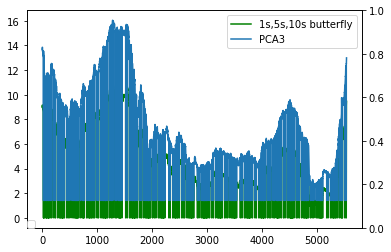

In [200]:
#synthetic portfolio plot (using top principal components from jacobi pca)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# 1 Month
# 3 Month
# 1 Year
# 20 Year
ax1.plot(-np_rates[:,0] + np_rates[:,1] + np_rates[:,2] + np_rates[:,6], label="Synthetic Portfolio", color='g')
ax1.plot(reconstruct1[:,2], label='PCA3')
ax2.legend(loc=(0, 0))
ax1.legend(loc=1)
plt.show()

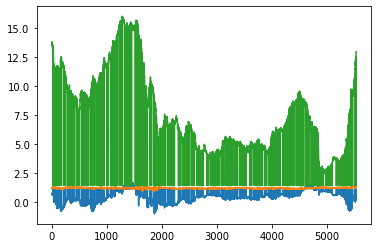

In [174]:
plt.plot(reconstruct1[:,:3])
plt.show()

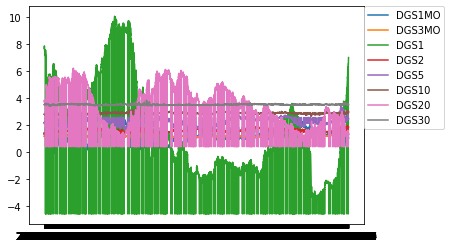

In [254]:
# reconstruct the data
reconstruct_all = np.dot(data,vecs.T)+mu_rates

for i in range(len(rates.columns)):
    plt.plot(rates.index, reconstruct_all[:, i], label=series[i])

plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0)
plt.show()


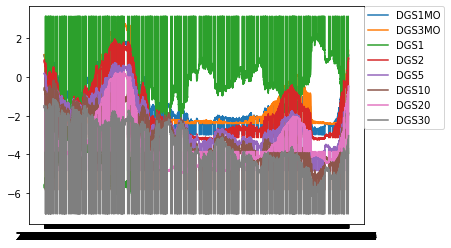

In [269]:
residuals = data - reconstruct_all
for i in range(len(rates.columns)):
    plt.plot(rates.index, residuals[:, i], label=series[i])

plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0)
plt.show()

In [116]:
# synthesize a 15 year Rate

In [266]:
(reconstruct_all[:,5] + reconstruct_all[:,6])/2

array([2.84378433, 2.85124877, 2.84100421, ..., 2.90919221, 2.95338352,
       3.02538974])

In [267]:
reconstruct_15year = (reconstruct_all[:,5] + reconstruct_all[:,6])/2

plot the predicted 15 year treasury rates

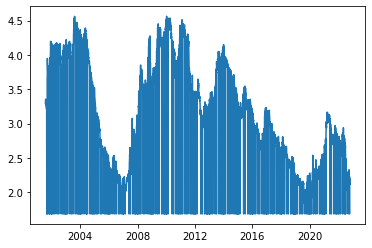

In [268]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%Y')

DF = pd.DataFrame()
DF['15 Yr Rates'] = reconstruct_15year
DF = DF.set_index(pd.to_datetime(rates.index))
plt.plot(DF)
plt.gca().xaxis.set_major_formatter(myFmt) # apply the format to the desired axis
plt.show()